# 0. Install and Import dependencies

In [265]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [1]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

In [2]:
SEED = 5756

# Specify parameters
stock_name = 'XOM'

# Window size for training
train_window_size = 10
train_start = '2023-01-01'
train_end = '2023-09-01'

test_window_size = 10
learn_iteration = 100000

# Model parameters
model_name = 'RecurrentPPO'

# Indicator parameters
sma_period = 10


# 1. Get Data

In [28]:
# import bs4 as bs    
# import pickle    
# import requests    
# import lxml    
# def save_sp500_tickers():
#     resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')        
#     soup = bs.BeautifulSoup(resp.text,'lxml')        
#     table = soup.find('table', {'class': 'wikitable sortable'})        

#     tickers = []

#     for row in table.findAll('tr')[1:]:
#         ticker = row.findAll('td')[0].text
#         tickers.append(ticker)

#     with open("sp500tickers.pickle", "wb") as f:
#         pickle.dump(tickers, f)
#     return tickers    

# tickers = save_sp500_tickers()
# tickers = [ticker.strip() for ticker in tickers]

# invalid_tickers = {'BRK.B', 'BF.B'}
# tickers = list(filter(lambda x: x not in invalid_tickers, tickers))

# kurtosis = []
# for ticker in tickers:
#     stock = qs.utils.download_returns(ticker)
#     stock = stock.loc['2020-01-01':]
#     kurtosis.append(qs.stats.kurtosis(stock))

# fortune500_df = pd.DataFrame({'tickers': tickers, 'kurtosis': kurtosis})
# fortune500_df.head()

In [35]:
import yfinance as yf
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_full_names = stock.info['longName']

In [37]:
yf.info('MSFT')

AttributeError: module 'yfinance' has no attribute 'info'

In [34]:
fortune500_df.sort_values(by='kurtosis', ascending=False).head(50)

,tickers,kurtosis
220,GL,147.659830
65,BIIB,90.145753
212,GEN,72.754401
272,KDP,49.388411
436,TRGP,45.808695
395,REG,41.330533
394,O,38.259353
192,FRT,37.168093
497,YUM,35.978629
355,OKE,35.261046


In [33]:
fortune500_df.to_csv('fortune500.csv')

In [4]:
gme = qs.utils.download_returns('GME')
gme = gme.loc['2010-07-01':'2023-02-10']

amd = qs.utils.download_returns('AMD')
amd = amd.loc['2010-07-01':'2023-02-10']

tsla = qs.utils.download_returns('TSLA')
tsla = tsla.loc['2010-07-01':'2023-02-10']
 
xom = qs.utils.download_returns('XOM')
xom = xom.loc['2010-07-01':'2023-02-10']
 
print("GameStop's kurtosis: ", qs.stats.kurtosis(gme).round(2))
print("Advances Micro Devices' kurtosis: ", qs.stats.kurtosis(amd).round(3))
print("Tesla's kurtosis: ", qs.stats.kurtosis(tsla).round(2))
print("ExxonMobil's kurtosis: ", qs.stats.kurtosis(xom).round(3))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

GameStop's kurtosis:  141.09
Advances Micro Devices' kurtosis:  17.125
Tesla's kurtosis:  5.04
ExxonMobil's kurtosis:  7.449


In [268]:
import yfinance as yf

df = yf.Ticker(stock_name)
df = df.history(period="max")
df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(76, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2024-01-02 00:00:00-05:00,99.990715,102.150641,99.921360,101.417458,23483000
2024-01-03 00:00:00-05:00,101.328290,102.665865,100.723913,102.269547,23490800
2024-01-04 00:00:00-05:00,103.121626,103.607112,101.110320,101.377831,19395200
2024-01-05 00:00:00-05:00,102.220003,102.447889,101.189579,101.684975,15825000
2024-01-08 00:00:00-05:00,99.802470,100.109613,97.989319,99.990715,23370100


In [269]:
TRAIN_ENV_FRAME_BOUND = (train_window_size, df[train_start:train_end].shape[0])
TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + test_window_size, df.shape[0])

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [270]:
df['SMA'] = TA.SMA(df, sma_period)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [271]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [272]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [273]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=train_window_size)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [274]:
from sb3_contrib import RecurrentPPO

if model_name == 'A2C':
    model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'RecurrentPPO':
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'PPO':
    model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'DQN':
    model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)

# 4. Evaluation

In [275]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=test_window_size)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>}


In [276]:
total_profit = round(info['total_profit'], 2)

# Report output
trade_strategy_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_trade_strategy.png"
report_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_reports.html"

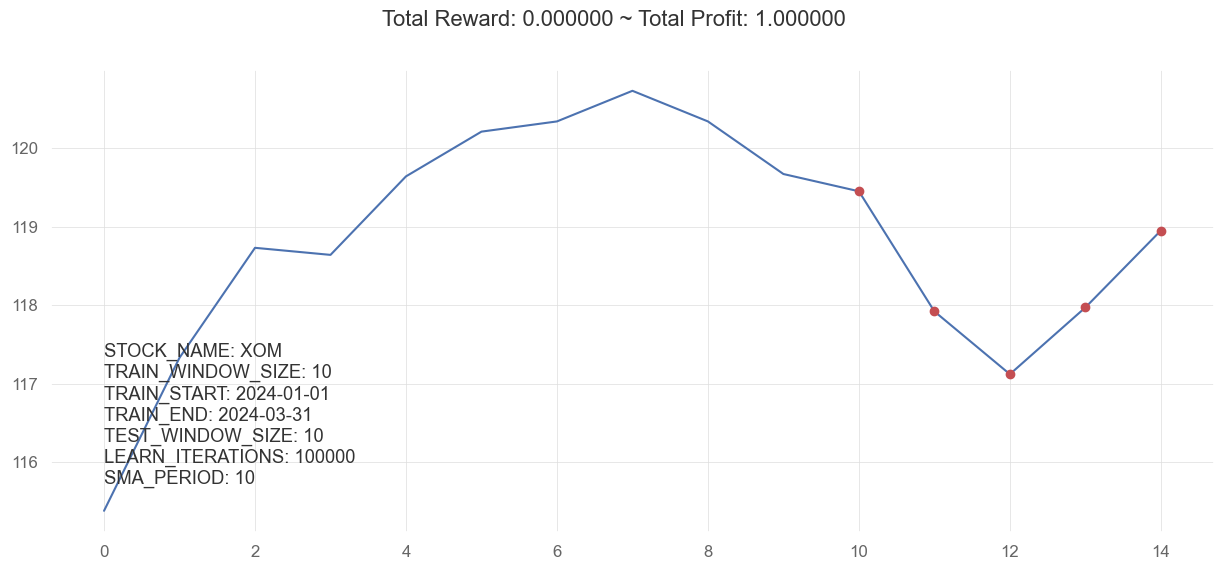

In [277]:
desc = f'STOCK_NAME: {stock_name}\nTRAIN_WINDOW_SIZE: {train_window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nTEST_WINDOW_SIZE: {test_window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: {sma_period}'

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.text(0, env.prices.max() - 5, desc)
plt.savefig(trade_strategy_output)
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old b

                           Strategy
-------------------------  ----------
Start Period               2024-04-17
End Period                 2024-04-19
Risk-Free Rate             0.0%
Time in Market             0.0%

Cumulative Return          0.0%
CAGR﹪                     0.0%

Sharpe                     -
Prob. Sharpe Ratio         -
Smart Sharpe               -
Sortino                    -
Smart Sortino              -
Sortino/√2                 -
Smart Sortino/√2           -
Omega                      -

Max Drawdown               %
Longest DD Days            -
Volatility (ann.)          0.0%
Calmar                     -
Skew                       0.0
Kurtosis                   -

Expected Daily %           0.0%
Expected Monthly %         0.0%
Expected Yearly %          0.0%
Kelly Criterion            -
Risk of Ruin               1.0%
Daily Value-at-Risk        -
Expected Shortfall (cVaR)  -

Max Consecutive Wins       0
Max Consecutive Losses     0
Gain/Pain Ratio            -
Gain/

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


None

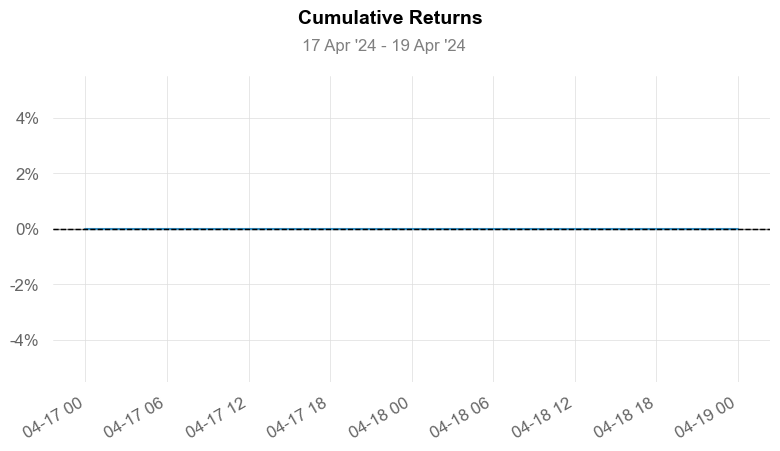

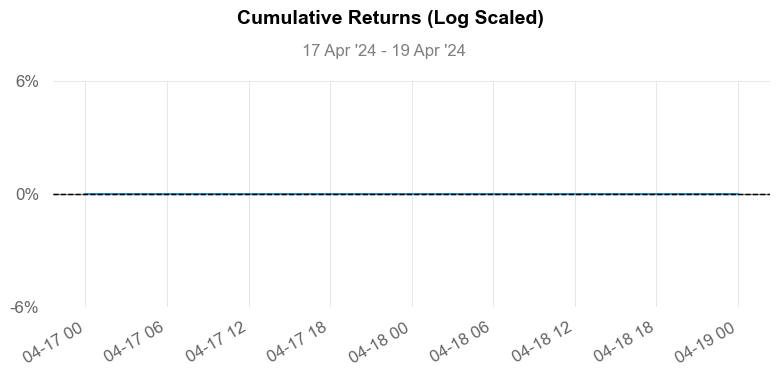

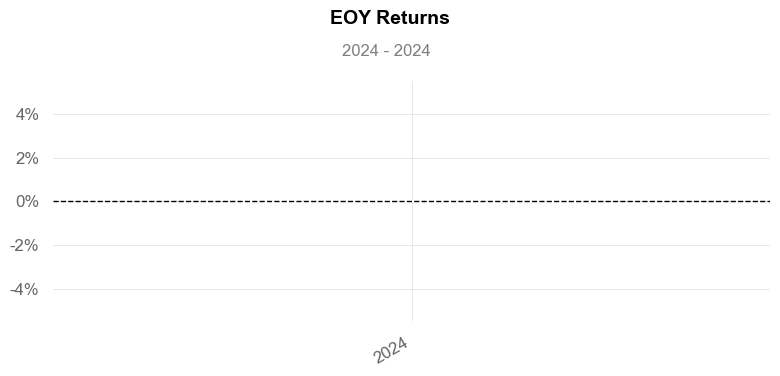

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


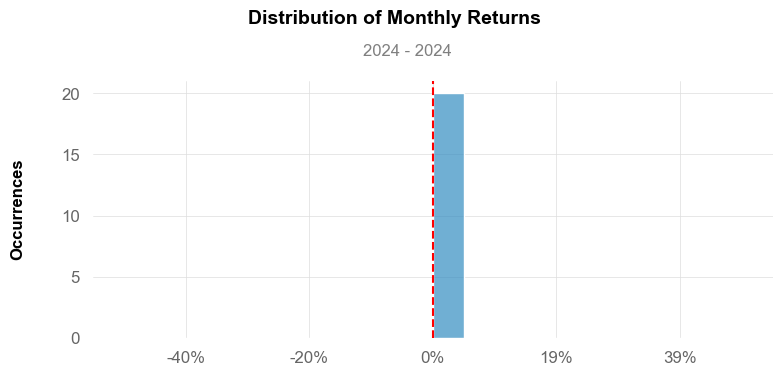

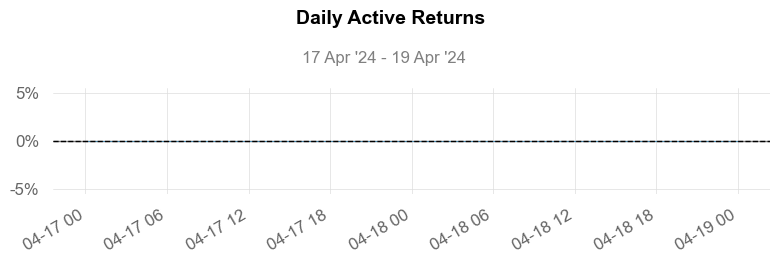

IndexError: index 0 is out of bounds for axis 0 with size 0

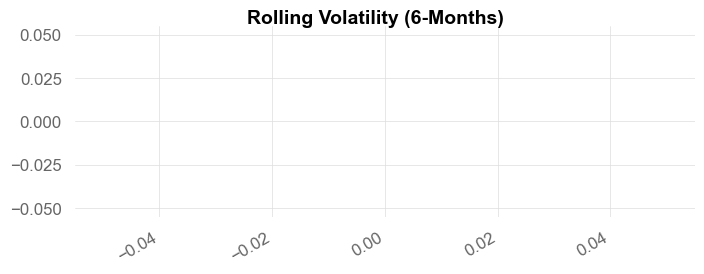

In [278]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=report_output)